In [1]:
import string
import re
from collections import Counter 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from urllib.parse import urlparse

import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy 
import en_core_web_sm
from spacymoji import Emoji

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, HdpModel

In [2]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

emoji = Emoji(nlp, merge_spans=False)
nlp.add_pipe(emoji, first=True)

In [3]:
df = pd.read_csv('reddit_wsb.csv')
df

,title,score,id,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56
...,...,...,...,...,...,...,...,...
37150,Could use some help here at the end of the day...,109,lt4i4u,https://i.redd.it/1rhnimof9vj61.jpg,37,1.614393e+09,NaN,2021-02-27 04:37:32
37151,The war has just begun,486,lt4fk0,https://v.redd.it/fcyia2xo8vj61,30,1.614393e+09,NaN,2021-02-27 04:34:21
37152,PSA: AMCX is not up because of AMC,33,lt4ci5,https://www.reddit.com/r/wallstreetbets/commen...,17,1.614393e+09,Tl;dr AMCX is a very undervalued company based...,2021-02-27 04:30:42
37153,Ape Combat 6: Liberation of Gamestopmeria,32,lt46qn,https://v.redd.it/x6b005am5vj61,3,1.614393e+09,NaN,2021-02-27 04:23:42


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37155 entries, 0 to 37154
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      37155 non-null  object 
 1   score      37155 non-null  int64  
 2   id         37155 non-null  object 
 3   url        37155 non-null  object 
 4   comms_num  37155 non-null  int64  
 5   created    37155 non-null  float64
 6   body       18718 non-null  object 
 7   timestamp  37155 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 2.3+ MB


# Selection of data from an appropriate interval

Data from the period between January 20 and February 10 was selected. Of the initial **37155** rows, **32511** remained after filtering by date. 

In [5]:
df = df.loc[(df.timestamp > '2021-01-19') & (df.timestamp < '2021-02-11')]
df = df.sort_values(by='timestamp').reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32511 entries, 0 to 32510
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      32511 non-null  object 
 1   score      32511 non-null  int64  
 2   id         32511 non-null  object 
 3   url        32511 non-null  object 
 4   comms_num  32511 non-null  int64  
 5   created    32511 non-null  float64
 6   body       16875 non-null  object 
 7   timestamp  32511 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 2.0+ MB


# Data analysis

In [6]:
df.dtypes

title         object
score          int64
id            object
url           object
comms_num      int64
created      float64
body          object
timestamp     object
dtype: object

## Two target columns.
The goal of the project will be to predict the most popular posts (with high score and/or many comments).

The high averages are due to very large maxima - the median is small.

In [7]:
df.describe().loc[:, ['score', 'comms_num']]

,score,comms_num
count,32511.000000,32511.000000
mean,996.129402,117.292578
std,7691.208445,1759.580068
min,0.000000,0.000000
25%,1.000000,1.000000
50%,9.000000,6.000000
75%,106.000000,28.000000
max,348241.000000,89050.000000


## Text preprocessing:
Steps:
- removing punctuation
- deletion of stopwords
- replacing emoji with tokens, e.g. emoji_rocket
- lemmatisation
- convert all letters to lowercase

In [8]:
def extract_emoji(sent):
    doc = sent
    res = []
    drop = False
    for token in doc:
        if drop:
            drop = False
            continue
        elif token.text == '\u200d':
            drop = True
            continue
        if token._.is_emoji:
            if token._.emoji_desc:
                res.append("emoji_"+"_".join(token._.emoji_desc.split()))
        else:
            res.append(token.text)
    res = ' '.join(res)
    return nlp(res.strip())


def preprocess_text(txt, join=True):
    doc = nlp(txt)
    txt_no_punctuation = [t for t in doc if t.text not in string.punctuation]
    txt_no_stopwords = [t for t in txt_no_punctuation if not t.is_stop]
    txt_no_stopwords = extract_emoji(txt_no_stopwords)
    txt_lemmatized = [t.lemma_ for t in txt_no_stopwords]
    if join:
        txt_lowered = ' '.join([t.lower() for t in txt_lemmatized])
    else:
        txt_lowered = [t.lower() for t in txt_lemmatized]
    return txt_lowered


print(preprocess_text('Hello, is that Better you?🚀🚀🚀'))

hello better emoji_rocket emoji_rocket emoji_rocket


In [9]:
tqdm.pandas()
df['preprocessed_title'] = df.title.progress_apply(preprocess_text)
df['preprocessed_body'] = df.body.fillna('').progress_apply(preprocess_text)

100%|██████████| 32511/32511 [04:58<00:00, 109.00it/s]


## Analysis of the title column
This column contains the titles of the Reddit posts

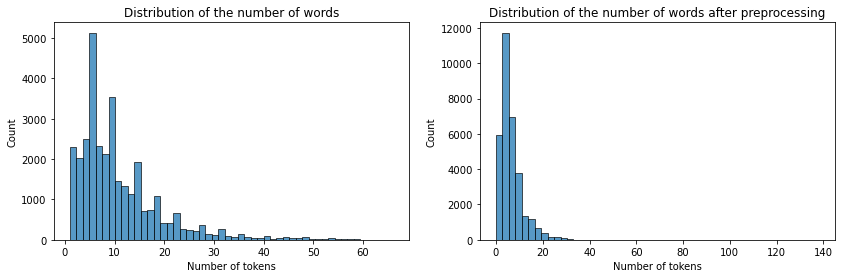

In [10]:
def plot_num_words_in_subplots(texts, texts_processed, yscale='linear'):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,4))

    sns.histplot(ax=ax[0], x=texts.str.split().apply(len), bins=50)
    ax[0].set(xlabel='Number of tokens', title='Distribution of the number of words')
    ax[0].set_yscale(yscale)
    
    sns.histplot(ax=ax[1], x=texts_processed.str.split().apply(len), bins=50)
    ax[1].set(xlabel='Number of tokens', title='Distribution of the number of words after preprocessing')
    ax[1].set_yscale(yscale) 
    
    plt.show()
    
plot_num_words_in_subplots(df.title, df.preprocessed_title)

**Most titles consist of several words.**

### The longest title after processing
Its length results from the fact that each emoji is treated as a word

In [11]:
df.title.loc[df.preprocessed_title.str.split().apply(len) == 138].item()

'TAKE IT TO THE FUCKING MOON 🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀'

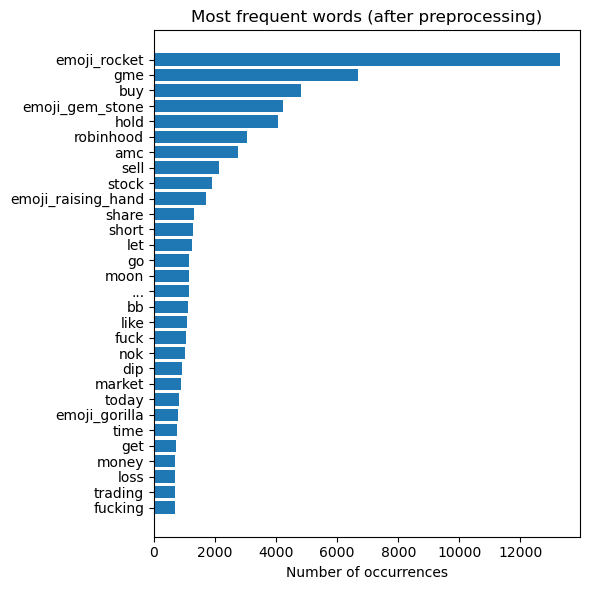

In [12]:
def plot_most_frequent_words(texts):
    words = " ".join(texts).split()
    
    cnt = Counter(words)
    y = [count for _, count in cnt.most_common(30)][::-1]
    x = [tag for tag, _ in cnt.most_common(30)][::-1]

    fig = plt.figure(figsize=(6, 6), dpi=100)
    plt.barh(x, y)
    plt.title("Most frequent words (after preprocessing)")
    plt.xlabel("Number of occurrences")
    plt.tight_layout()
    plt.show()

plot_most_frequent_words(df.preprocessed_title)

### Specific terminology appears here:
- **rocket / emoji_rocket / fly / to the moon:** denotes a belief that share prices will rise
- **gme** - GameStop company, whose shares users bought
- **amc** - AMC Entertainment, whose shares were also bought by Reddit users
- **diamond / hold / emoji_gemstone / emoji_gemstone + emoji_raising_hands:** - they encourage people to hold on to their shares and not sell them, which will cause the price to rise further
- **robinhood** - a platform on which users bought shares
- **monkey / emoji_gorilla / ape / apes together strong** - a slogan taken from the movie Rise of the Planet of the Apes (2011), which means that users must stick together
- other words are mostly related to the stock market

## Analysis of the body column
This column contains the text of posts uploaded to reddit. Some posts only have a link, image, or video, and then they don't have a body

In [13]:
print(f'Number of rows WITHOUT a body: {df.body.isna().sum()}')
print(f'Number of rows WITH a body: {df.body.count()}')

Number of rows WITHOUT a body: 15636
Number of rows WITH a body: 16875


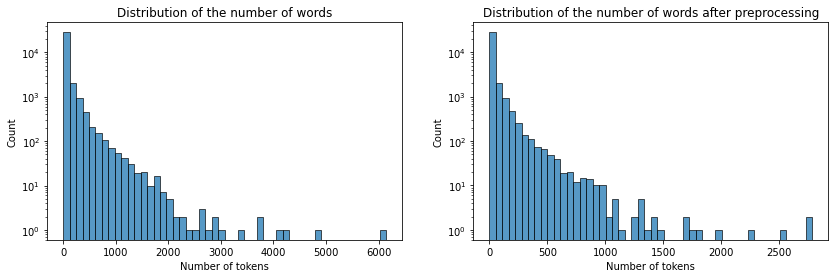

In [14]:
plot_num_words_in_subplots(df.body.fillna(''), df.preprocessed_body, yscale='log')

**After preprocessing, the length of the body is reduced because there are not so many emoji and some words are removed**

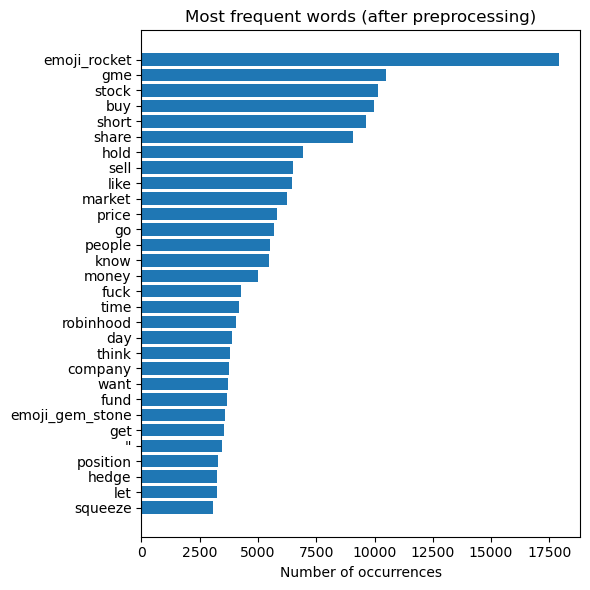

In [15]:
plot_most_frequent_words(df.preprocessed_body)

**The words are similar to those in the titles**

## Analysis of the id column
The column contains unique identifiers for posts.

In [16]:
print(f'Number of ids: {len(df.id.unique())}')
df.id.sample(5)

Number of ids: 32511


4205     l6zgjf
21961    layh6t
28244    ld4xhx
20773    lagvnn
19931    l9xkny
Name: id, dtype: object

## Analysis of the url column
The url column contains links attached to posts. One post always has one link. Most often these are links to the original posts on reddit. Apart from these, the most commonly attached page types include:
* twitter
* websites with video clips (youtube, streamable)
* photo sharing websites (imgur, ibb)
* news portals, rather oriented to finance and investment  (finance.yahoo, bloomberg, cnbc, wsj, reuters)

**In the first step, a column with the top-level domain is created**

In [17]:
df['url_netloc'] = df.url.apply(lambda path: urlparse(path).netloc)

In [18]:
cnt_urls = Counter(df.url_netloc)
cnt_urls_sorted = cnt_urls.most_common()[::-1]

dict_common_urls = {tag: count for tag, count in cnt_urls_sorted if count > 10}
print(f'Number of unique links {len(cnt_urls)}')
print(f'Number of unique most frequent links {len(dict_common_urls)}')
# print(f'Najczęściej wystepujące linki:\n {cnt_urls.most_common(10)}')

Number of unique links 402
Number of unique most frequent links 19


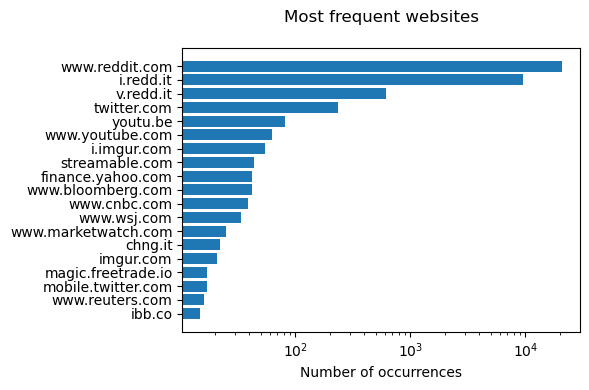

In [19]:
fig = plt.figure(figsize=(6, 4), dpi= 100, facecolor='w', edgecolor='k')
# count_of_reddit_urls = sum(list(dict_common_urls.values())[-3:])
plt.barh(list(dict_common_urls.keys()), list(dict_common_urls.values()))
plt.title(f"Most frequent websites\n")
plt.xlabel("Number of occurrences")
plt.xscale('log')
plt.tight_layout()
plt.show()

### Grouping of the url's

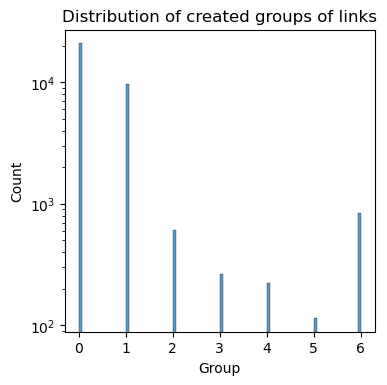

In [20]:
def create_grouping_dict(urls, verbose=False):
    d = {}
    grouped = set()
    
    patterns = [
        r".*(reddit).*",  # reddit self-posts
        r"(i.redd.it)",  # reddit images
        r"(v.redd.it)",  # reddit videos
        r".*(twitter|facebook|instagram).*",  # social media
        r".*(youtu|twitch|streamable|vimeo|tiktok).*",  # other videos
        r".*(img|gfy|ibb).*"  # other images
    ]
    
    for i, pattern in enumerate(patterns):
        matched = list(filter(re.compile(pattern).match, urls))
        d.update({m:i for m in matched})
        grouped.update(matched)
        if verbose:
            print(f'{i}: {matched}')

    # last group for all unmatched urls, mostly news articles 
    others = set(urls) - grouped
    d.update({o:i+1 for o in others})
    if verbose:
        print(f'others: {others}')
        print(set(d.keys()) == set(urls))
    
    return d

mapping = create_grouping_dict(df.url_netloc.unique().tolist())

fig = plt.figure(figsize=(4, 4), dpi= 100, facecolor='w', edgecolor='k')
sns.histplot(df.url_netloc.map(mapping))
plt.yscale('log')
plt.xlabel('Group')
plt.ylabel('Count')
plt.title('Distribution of created groups of links')
plt.show()

 - **Group 0** collects so-called **self-posts** (source: [reddit/r/help](https://www.reddit.com/r/help/comments/16secs/what_is_a_self_post/)), which contain text alone and do not lead to external pages.
 - **Group 1** collects images added via i.redd.it
 - **Group 2** collects videos added via v.redd.it
 - **Group 3** collects links to social media
 - **Group 4** gathers videos uploaded through external services
 - **Group 5** gathers photos and images uploaded through external services
 - **Group 6** gathers other links, usually from news sites

## Analysis of the score column
This column contains **outdated values**. In the next steps, it will be necessary to use the API to update them.

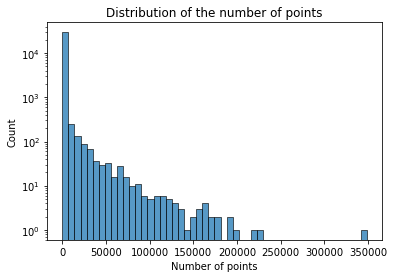

The number of rows with a score value equal to 0: 2064


count     32511.000000
mean        996.129402
std        7691.208445
min           0.000000
25%           1.000000
50%           9.000000
75%         106.000000
max      348241.000000
Name: score, dtype: float64

In [21]:
ax = sns.histplot(x=df.score.loc[df.score > 0], bins=50)
ax.set(xlabel='Number of points', ylabel='Count', title='Distribution of the number of points')
plt.yscale('log')
plt.show()

print(f'The number of rows with a score value equal to 0: {df.score.loc[df.score == 0].count()}')
df.score.describe()

## Analysis of the comms_num column
Just like the number of scores, the values in this column are also outdated and will need to be updated using the Reddit API.

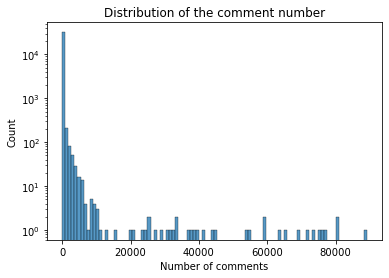

Number of rows with number of comments equal to 0: 6206


count    32511.000000
mean       117.292578
std       1759.580068
min          0.000000
25%          1.000000
50%          6.000000
75%         28.000000
max      89050.000000
Name: comms_num, dtype: float64

In [22]:
ax = sns.histplot(x=df.comms_num, bins=100)
ax.set(xlabel='Number of comments', ylabel='Count', title='Distribution of the comment number')
plt.yscale('log')
plt.show()

print(f'Number of rows with number of comments equal to 0: {df.comms_num.loc[df.comms_num == 0].count()}')
df.comms_num.describe()

## Analysis of the created column
This column corresponds to the timestamp column. We have decided to use timestamp.

In [23]:
df.created.astype(int).sample(5)

19168    1612111979
28120    1612545293
27012    1612492377
4175     1611876020
16065    1611900323
Name: created, dtype: int64

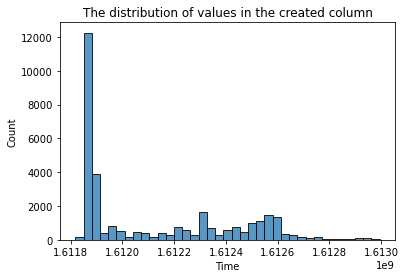

In [24]:
ax = sns.histplot(df.created)
ax.set(xlabel='Time', title='The distribution of values in the created column')
plt.show()

## Analysis of the timestamp column
The column contains the date when the post was created. The analysis covers the period from 20.01.2021 to 10.02.2021. The time of posts in the column is shifted in relation to the Polish one by **9 hours forward**. The main events related to GameStop's share price took place on January 28-29, 2021.

In [25]:
ts_dt = pd.to_datetime(df.timestamp)

In [26]:
print(f'First day in the collection {ts_dt.min()}')
print(f'Last day in the collection {ts_dt.max()}')

First day in the collection 2021-01-28 09:08:16
Last day in the collection 2021-02-10 23:51:19


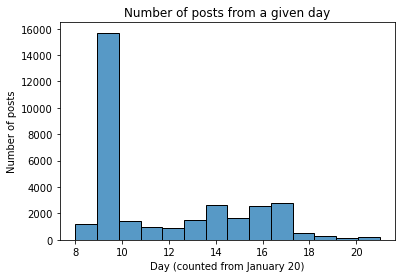

In [27]:
sns.histplot(ts_dt.dt.dayofyear - pd.Timestamp('2021-01-20').dayofyear, bins=14)
plt.ylabel("Number of posts")
plt.title("Number of posts from a given day")
plt.xlabel("Day (counted from January 20)")
plt.show()

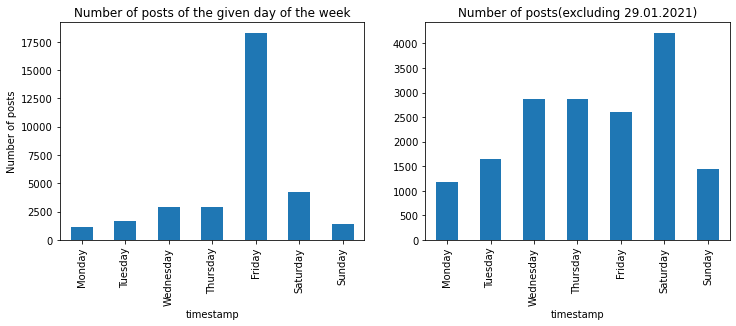

In [28]:
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ts_dt.groupby(ts_dt.dt.weekday).count().plot(kind='bar', ax=ax[0])
ax[0].set_xticklabels(day_names)
ax[0].set_ylabel("Number of posts")
ax[0].set_title("Number of posts of the given day of the week")

without_01_29_21 = ts_dt.loc[ts_dt.dt.date != pd.Timestamp('2021-01-29')].dt.weekday

ts_dt.groupby(without_01_29_21).count().plot(kind='bar', ax=ax[1])

ax[1].set_xticklabels(day_names)
ax[1].set_title("Number of posts(excluding 29.01.2021)")
plt.show()

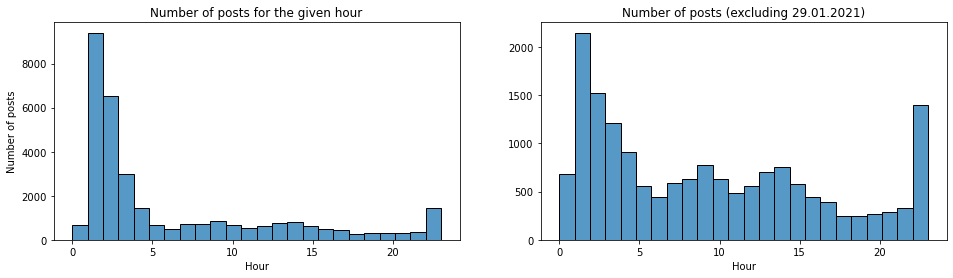

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

sns.histplot(ts_dt.dt.hour, ax=ax[0], bins=24)
ax[0].set_ylabel("Number of posts")
ax[0].set_title("Number of posts for the given hour")
ax[0].set_xlabel("Hour")

sns.histplot(ts_dt.loc[ts_dt.dt.date != pd.Timestamp('2021-01-29')].dt.hour, ax=ax[1], bins=24)
ax[1].set_ylabel("")
ax[1].set_title("Number of posts (excluding 29.01.2021)")
ax[1].set_xlabel("Hour")
plt.show()

# Analysis of words in posts according to score

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

# Term document freq - number of documents where the term t appears
def TDF(df, feature="title"):
    vectorizer = CountVectorizer()
    X_vec = vectorizer.fit_transform(df[feature].fillna(""))
    X_vec[X_vec>0] = 1
    doc_f = {w: f/X_vec.shape[0] for w, f in zip(vectorizer.get_feature_names(), 
                          np.array(X_vec.sum(axis=0))[0])}
    doc_f = dict(sorted(doc_f.items(), key=lambda item: item[1], reverse=True))
    return doc_f

def compare_TDF(best_tdf, worst_tdf, top_k=20):
    words = set(list(best_tdf.keys()) + list(worst_tdf.keys()))
    diff = {}
    for w in words:
        if w in best_tdf and w in worst_tdf:
            diff[w] = best_tdf[w]-worst_tdf[w]
        elif w in best_tdf:
            diff[w] = best_tdf[w]
        else:
            diff[w] = -worst_tdf[w]
    return dict(sorted(diff.items(), key=lambda item: item[1], reverse=True)[:top_k])


def top_k_words(word2score, top_k):
    for i, (word, value) in enumerate(word2score.items()):
        if i>top_k-1:
            break
        print(f"{word:20}: {value:.5f}")

In [31]:
best_ratio = int(1*len(df)/10)
worst_ratio = int(5*len(df)/10)
best_score = df.nlargest(int(1*len(df)/10), "score")
worst_score = df.nsmallest(int(5*len(df)/10), "score")
best_perc_ratio = int(np.round(best_ratio/len(df), 2) * 100)
worst_perc_ratio = int(np.round(worst_ratio/len(df), 2) * 100)
print(f"{best_perc_ratio}% posts with highest score - min score is: {best_score.score.min()}")
print(f"{worst_perc_ratio}% posts with loweset score - max score is: {worst_score.score.max()}")

10% posts with highest score - min score is: 486
50% posts with loweset score - max score is: 9


## Analysis of words in posts with high scores

**Title**

In [32]:
best_score_tdf_title = TDF(best_score, feature="preprocessed_title")
print(list(best_score_tdf_title.keys())[:20])

['gme', 'emoji_rocket', 'emoji_gem_stone', 'hold', 'buy', 'amc', 'sell', 'robinhood', 'share', 'short', 'emoji_raising_hand', 'stock', 'like', 'wsb', 'today', 'moon', 'squeeze', 'go', 'gamestop', 'market']


**Body**

In [33]:
best_score_tdf_body = TDF(best_score, feature="preprocessed_body")
print(list(best_score_tdf_body.keys())[:20])

['gme', 'stock', 'buy', 'like', 'share', 'hold', 'know', 'short', 'go', 'sell', 'people', 'day', 'time', 'money', 'market', 'financial', 'https', 'edit', 'get', 'want']


## Analysis of words in posts with low scores

**Title**

In [37]:
worst_score_tdf_title = TDF(worst_score, feature="preprocessed_title")
print(list(worst_score_tdf_title.keys())[:20])

['gme', 'buy', 'robinhood', 'hold', 'amc', 'emoji_rocket', 'sell', 'stock', 'let', 'bb', 'nok', 'go', 'fuck', 'moon', 'app', 'emoji_gem_stone', 'short', 'dip', 'trade', 'market']


**Body**

In [38]:
worst_score_tdf_body = TDF(worst_score, feature="preprocessed_body")
print(list(worst_score_tdf_body.keys())[:20])

['buy', 'gme', 'stock', 'hold', 'robinhood', 'sell', 'like', 'go', 'know', 'let', 'market', 'money', 'share', 'people', 'amc', 'fuck', 'emoji_rocket', 'short', 'want', 'get']


## Comparison of words between posts with high and low score

**Titles comparison**

In [39]:
top_20_tdf_score_title = compare_TDF(best_score_tdf_title, worst_score_tdf_title, top_k=20)
top_k_words(top_20_tdf_score_title, top_k=20)

emoji_gem_stone     : 0.11418
emoji_rocket        : 0.07468
gme                 : 0.06035
emoji_raising_hand  : 0.04042
share               : 0.02855
short               : 0.02535
wsb                 : 0.02289
week                : 0.02030
diamond             : 0.01950
retard              : 0.01932
gamestop            : 0.01876
hand                : 0.01809
squeeze             : 0.01772
like                : 0.01630
emoji_open_hand     : 0.01587
2021                : 0.01581
day                 : 0.01538
hedge               : 0.01526
today               : 0.01476
say                 : 0.01470


**Bodies Comparison**

In [40]:
top_20_tdf_score_body = compare_TDF(best_score_tdf_body, worst_score_tdf_body, top_k=20)
top_k_words(top_20_tdf_score_body, top_k=20)

edit                : 0.10994
share               : 0.10261
short               : 0.09357
day                 : 0.09253
financial           : 0.09240
like                : 0.08797
know                : 0.08582
people              : 0.08459
time                : 0.07764
go                  : 0.07512
post                : 0.07505
week                : 0.07352
com                 : 0.07204
https               : 0.07198
squeeze             : 0.06896
position            : 0.06829
price               : 0.06638
sell                : 0.06626
advice              : 0.06583
get                 : 0.06576


## Analysis of words in posts with score 0

**Title**

In [38]:
score_0_tdf_title = TDF(df[df.score==0], feature="preprocessed_title")
print(list(score_0_tdf_title.keys())[:20])

['gme', 'buy', 'stock', 'emoji_rocket', 'short', 'sell', 'squeeze', 'amc', 'hold', 'let', 'moon', 'go', 'robinhood', 'new', 'like', 'money', 'good', 'gamestop', 'time', 'know']


**Body**

In [39]:
score_0_tdf_body = TDF(df[df.score==0], feature="preprocessed_body")
print(list(score_0_tdf_body.keys())[:20])

['stock', 'gme', 'buy', 'like', 'go', 'short', 'money', 'know', 'hold', 'share', 'people', 'sell', 'think', 'market', 'get', 'time', 'good', 'want', 'price', 'let']


## Analysis of words in posts with the smallest number of comments

**Title**

In [41]:
smallest_comm_title = df[df.comms_num<=df.comms_num.median()]
smallest_comm_tdf_title = TDF(smallest_comm_title, feature="preprocessed_title")
print(list(smallest_comm_tdf_title.keys())[:20])

['gme', 'buy', 'robinhood', 'hold', 'emoji_rocket', 'amc', 'sell', 'stock', 'emoji_gem_stone', 'let', 'bb', 'nok', 'fuck', 'moon', 'go', 'dip', 'market', 'app', 'share', 'trade']


**Body**

In [42]:
smallest_comm_body = df[df.comms_num<=df.comms_num.median()]
smallest_comm_tdf_body = TDF(smallest_comm_body, feature="preprocessed_body")
print(list(smallest_comm_tdf_body.keys())[:20])

['buy', 'gme', 'hold', 'stock', 'robinhood', 'sell', 'like', 'let', 'emoji_rocket', 'go', 'market', 'amc', 'fuck', 'know', 'share', 'money', 'people', 'https', 'short', 'want']


## Analysis of words in posts with the highest number of comments

**Title**

In [43]:
most_comm_title = df.nlargest(int(1*len(df)/100), "comms_num")
most_comm_tdf_title = TDF(most_comm_title, feature="preprocessed_title")
print(list(most_comm_tdf_title.keys())[:20])

['gme', '2021', 'thread', 'discussion', 'emoji_rocket', 'february', 'daily', 'emoji_gem_stone', 'wsb', 'buy', 'hold', 'short', 'amc', 'robinhood', 'sell', 'like', 'january', 'share', 'tomorrow', 'day']


**Body**

In [44]:
most_comm_body = df.nlargest(int(1*len(df)/100), "comms_num")
most_comm_tdf_body = TDF(most_comm_body, feature="preprocessed_body")
print(list(most_comm_tdf_body.keys())[:20])

['people', 'gme', 'day', 'com', 'https', 'like', 'buy', 'reddit', 'week', 'www', 'stock', 'know', 'wsb', 'go', 'good', 'new', 'try', 'money', 'hold', 'time']


## Comparison of words in posts with the highest and lowest number of comments

**Titles comparison**

In [45]:
top_20_tdf_comm_title_compare = compare_TDF(most_comm_tdf_title,
                                            smallest_comm_tdf_title, top_k=20)
top_k_words(top_20_tdf_comm_title_compare, top_k=20)

2021                : 0.13037
gme                 : 0.10446
thread              : 0.09320
discussion          : 0.09134
february            : 0.07915
daily               : 0.07601
wsb                 : 0.05297
january             : 0.03903
tomorrow            : 0.03606
megathread          : 0.03366
28                  : 0.02672
day                 : 0.02638
squeeze             : 0.02590
emoji_gem_stone     : 0.02587
short               : 0.02421
deepfuckingvalue    : 0.02292
moves               : 0.02154
01                  : 0.02087
wallstreetbets      : 0.01960
unpinned            : 0.01846


**Bodies comparison**

In [46]:
top_20_tdf_comm_body_compare = compare_TDF(most_comm_tdf_body,
                                           smallest_comm_tdf_body, top_k=20)
top_k_words(top_20_tdf_comm_body_compare, top_k=20)

people              : 0.21130
day                 : 0.21115
com                 : 0.20217
reddit              : 0.20183
week                : 0.18732
www                 : 0.18435
https               : 0.18218
wsb                 : 0.17785
edit                : 0.16311
new                 : 0.16254
good                : 0.15860
read                : 0.15471
like                : 0.15338
try                 : 0.15097
dd                  : 0.13736
know                : 0.13696
wallstreetbet       : 0.13537
time                : 0.13352
money               : 0.13112
go                  : 0.12765


# Feature engineering
## Text attributes

Ogólne:
- Number of characters in the unprocessed title and body
- Number of words in processed title and body
- What percentage of letters are capital letters?
- Sentiment analysis

Emoji:
- What percentage of words are emoji?
- Number of emoticons in the title
- Number of emoticons in the body
- Total number of emoticons
- Are there any emoticons (binary feature)
- Ratio of the number of unique emoticons to the total number of emoticons in the post
    - A smaller value indicates the use of mostly the same emoticons, while a larger value indicates a greater variety of emoticons. In posts without any emoticons, a value of 1 has been inserted.
- Vector counting the most common emoticons

In [47]:
sid = SentimentIntensityAnalyzer()

# Source: https://github.com/cjhutto/vaderSentiment
def vader_sentiment(text: str):
    d = sid.polarity_scores(text)
    return d['pos'], d['neu'], d['neg'], d['compound']


def num_words(txt):
    return len(txt.split())


def calc_percent_of_emoji(txt):
    words = txt.split()
    if not words:
        return 0
    else:
        return sum([w.startswith('emoji_') for w in words]) / len(words)
    
    
def calc_percent_of_capital_letters(txt):
    alpha_txt = [l for l in txt if l.isalpha()]
    if not alpha_txt:
        return 0
    else:
        return sum([l.isupper() for l in alpha_txt]) / len(alpha_txt)
    

def count_unique_emoji(text):
    em = []
    for token in text.split():
        if "emoji_" in token:
            em.append(token)
    return len(np.unique(em))


def count_emojis(df):
    emojis = []
    for text in df[df["is_emoji"]>0]["full_text"]:
        for token in text.split():
            if "emoji_" in token:
                emojis.append(token)
                
    em, em_count = np.unique(emojis, return_counts=True)
    count_sort_ind = np.argsort(-em_count)
    em = em[count_sort_ind]
    em_count = em_count[count_sort_ind]
    return em, em_count

    
def get_text_features(df: pd.DataFrame):
    df['full_text'] = df['preprocessed_title'].fillna('') + ' ' + df['preprocessed_body'].fillna('')
    df['full_text_length'] = df['full_text'].apply(lambda x: len(x))
    
    df['num_letters_title'] = df.title.str.len()
    df['num_letters_body'] = df.body.str.len()
    
    df['num_words_title'] = df.preprocessed_title.fillna("").apply(num_words)
    df['num_words_body'] = df.preprocessed_body.fillna("").apply(num_words)
    
    df['num_unique_words_title'] = df.preprocessed_title.str.split().apply(lambda x: len(set(x)))
    df['num_unique_words_body'] = df.preprocessed_body.str.split().apply(lambda x: len(set(x)))
    
    df['capital_title_perc'] = df.title.apply(calc_percent_of_capital_letters)
    df['capital_body_perc'] = df.body.fillna('').apply(calc_percent_of_capital_letters)
    
    p = df.full_text.transform(vader_sentiment).to_list()
    df[['VS_pos','VS_neu','VS_neg','compound']] = pd.DataFrame(p, columns=['VS_pos','VS_neu','VS_neg','compound'])
    df['sentiment'] = df['compound'].apply(lambda c: 'pos' if c>0.1 else 'neg' if c<-0.1 else 'neu')

def get_emoji_features(df):
    df['emoji_title_perc'] = df["preprocessed_title"].fillna("").apply(calc_percent_of_emoji)
    df['emoji_body_perc'] = df["preprocessed_body"].fillna("").apply(calc_percent_of_emoji)
    df["title_emoji_count"] = df["preprocessed_title"].fillna("").apply(lambda x: x.count("emoji_"))
    df["body_emoji_count"] = df["preprocessed_body"].fillna("").apply(lambda x: x.count("emoji_"))
    df["total_emoji_count"] = df['title_emoji_count'] + df['body_emoji_count']
    df["is_emoji"] = df["total_emoji_count"].apply(lambda x: int(x>0))
    df["unique_emojis"] = 0
    df.loc[df["is_emoji"]>0, "unique_emojis"] = df.loc[df["is_emoji"]>0, "full_text"].apply(count_unique_emoji)
    df["repeated_emojis_ratio"] = (df["unique_emojis"] / df["total_emoji_count"]).fillna(1)
    em, em_count = count_emojis(df)
    popular_emojis = em[:20]
    for popular_em in popular_emojis:
        df[popular_em] = df.full_text.apply(lambda x: x.count(popular_em))

get_text_features(df)
get_emoji_features(df)

## LDA Topic Modeling

Code taken from https://www.kaggle.com/radema/yolo-topic-modeling

In [48]:
def make_bigrams(texts, bigram_mod):
    return [bigram_mod[doc] for doc in texts]


def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=num_topics,
                                                alpha='auto',
                                                eta='auto')#learn asymmetric priors
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values


def topic_modeling(df):
    texts = df.full_text.sample(frac=1).dropna().unique()
    data_words = [sent.split() for sent in texts]
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    data_words = make_bigrams(data_words, bigram_mod)
    id2word = corpora.Dictionary(data_words)
    id2word.filter_extremes(no_below = 10, no_above=0.25)
    lemmas = data_words
    corpus = [id2word.doc2bow(text) for text in data_words]
    model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                            corpus=corpus, 
                                                            texts=data_words, 
                                                            start=3, 
                                                            limit=25,
                                                            step=3)
    x = range(3, 25, 3)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    optimal_model = model_list[np.argmax(coherence_values)]
    return optimal_model, corpus, texts, id2word, bigram_mod, trigram_mod, bigram, trigram


def format_topics_sentences(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: x[1], reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num, topn=7)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


def build_corpus(texts:pd.Series, dictionary, bigram_mod):
    docs = [sent.split() for sent in texts]
    data_words = make_bigrams(docs, bigram_mod)
    corpus = [dictionary.doc2bow(text) for text in data_words]
    return corpus

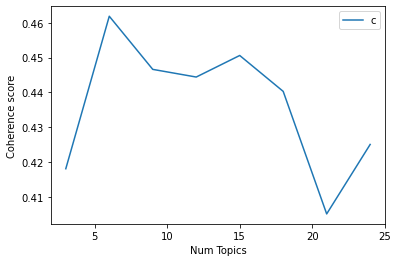

In [49]:
optimal_model, corpus, texts, id2word, bigram_mod, trigram_mod, bigram, trigram = topic_modeling(df)

In [50]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.9331,"people, like, know, stock, money, go, think",looking advice invest guillotine future pretty...
1,1,3.0,0.4933,"robinhood, account, stock, rh, trade, app, fuck",fuck strange robinhood
2,2,0.0,0.5912,"hold, amc, sell, let, bb, nok, fuck",calm portfolio go 55 emoji_gem_stone emoji_rai...
3,3,1.0,0.4309,"company, year, stock, silver, x200b, market, e...",wept rocket conquer
4,4,3.0,0.8228,"robinhood, account, stock, rh, trade, app, fuck",robinhood block user buy gme
5,5,1.0,0.4674,"company, year, stock, silver, x200b, market, e...",start act like retard give zero fuck diversifi...
6,6,5.0,0.9073,"emoji_rocket, emoji_gem_stone, emoji_raising_h...",everybody ready emoji_rocket emoji_gorilla emo...
7,7,4.0,0.8424,"people, like, know, stock, money, go, think",wargame hedge fund tldr strictly entertainment...
8,8,0.0,0.6402,"hold, amc, sell, let, bb, nok, fuck",ride sons gondor
9,9,4.0,0.8295,"people, like, know, stock, money, go, think",finally media get


In [51]:
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf,
                                      grp.sort_values(['Perc_Contribution'], 
                                                      ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9941,"hold, amc, sell, let, bb, nok, fuck",daily discussion thread 2 february 1 2021 dail...
1,1.0,0.9874,"company, year, stock, silver, x200b, market, e...",bet goev pretty excited goev talk apple build ...
2,2.0,0.9990,"short, share, price, stock, market, position, ...",dd greek symbols option explained analysis opt...
3,3.0,0.9778,"robinhood, account, stock, rh, trade, app, fuck",need list trading platform sell wsb stock trad...
4,4.0,0.9960,"people, like, know, stock, money, go, think",people vs hedge fund stock exchange suppose ev...
5,5.0,0.9990,"emoji_rocket, emoji_gem_stone, emoji_raising_h...",moon emoji_gem_stone emoji_raised_hand emoji_g...


In [52]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[
    ['Dominant_Topic', 'Topic_Keywords']
].drop_duplicates()

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords.sort_values(by='Dominant_Topic').reset_index() , 
                                topic_counts.sort_index()
                                , topic_contribution.sort_index()
                               ], axis=1).drop(columns='index')

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.sort_values(by='Num_Documents', ascending=False)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
4.0,4.0,"people, like, know, stock, money, go, think",8990,0.2837
0.0,0.0,"hold, amc, sell, let, bb, nok, fuck",6955,0.2195
3.0,3.0,"robinhood, account, stock, rh, trade, app, fuck",5627,0.1776
5.0,5.0,"emoji_rocket, emoji_gem_stone, emoji_raising_h...",4557,0.1438
2.0,2.0,"short, share, price, stock, market, position, ...",3917,0.1236
1.0,1.0,"company, year, stock, silver, x200b, market, e...",1639,0.0517


In [53]:
new_corpus = build_corpus(df.full_text, dictionary=id2word, bigram_mod=bigram_mod)
topics_docs= list(optimal_model.get_document_topics(new_corpus, minimum_probability=0.0))
lda_topics = [sorted(topics, key=lambda x: x[1], reverse=True)[0] for topics in topics_docs]
df = pd.concat([df,pd.DataFrame(lda_topics, columns=['lda_topic','lda_topic_prob'])], axis = 1)
# del topics_docs, lda_topics

In [54]:
### Store dictionary and lda model
from gensim.test.utils import datapath

optimal_model.save('lda_model')
id2word.save('dictionary')

bigram_mod.save('./Models/bigram_mod')
trigram_mod.save('./Models/trigram_mod')
bigram.save('./bigram')
trigram.save('./trigram')

## Other attributes
- Grouped links
- Day of the week
- Time as number of minutes since midnight
- Time as number of hours since midnight
- Week of the year since January 20
- Number of days from January 20

In [55]:
def get_url_features(df):
    mapping = create_grouping_dict(df.url_netloc.unique().tolist())
    df['sub_group'] = df.url_netloc.map(mapping)
    # merge urls with images (1 and 5) and videos (2 and 4)
    # change 6 to 4 for continuity
    df['group'] = df.sub_group.map({0: 0, 1: 1, 2:2, 3:3, 4:2, 5:1, 6:4})
    
    
def get_time_features(df):
    ts_dt = pd.to_datetime(df.timestamp)
    df['weekday'] = ts_dt.dt.weekday
    df['minutes_from_midnight'] = ((ts_dt - ts_dt.dt.normalize()) / pd.Timedelta(minutes=1)).astype(int)
    df['hours_from_midnight'] = ts_dt.dt.hour
    df['weeks_from_start'] = ts_dt.dt.isocalendar().week - pd.Timestamp('2021-01-20').isocalendar()[1]
    df['days_from_start'] = ts_dt.dt.dayofyear - pd.Timestamp('2021-01-20').dayofyear

In [56]:
get_url_features(df)
get_time_features(df)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32511 entries, 0 to 32510
Data columns (total 63 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   title                           32511 non-null  object 
 1   score                           32511 non-null  int64  
 2   id                              32511 non-null  object 
 3   url                             32511 non-null  object 
 4   comms_num                       32511 non-null  int64  
 5   created                         32511 non-null  float64
 6   body                            16875 non-null  object 
 7   timestamp                       32511 non-null  object 
 8   preprocessed_title              32511 non-null  object 
 9   preprocessed_body               32511 non-null  object 
 10  url_netloc                      32511 non-null  object 
 11  full_text                       32511 non-null  object 
 12  full_text_length                

In [58]:
df.to_csv('reddit_etap_1_v4.csv')